In [6]:
import matplotlib.pyplot as plt
import numpy as np
import random
import npc_sessions
import polars as pl
import pandas as pd
from matplotlib.ticker import PercentFormatter

In [3]:
session = npc_sessions.DynamicRoutingSession('668755_20230831')
units = npc_sessions.good_units(session.units)

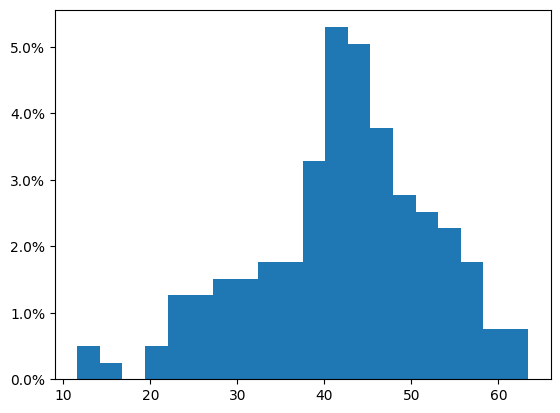

In [7]:
units_probeA = units[units['electrode_group_name'] == 'probeA']
plt.hist(units_probeA['drift_ptp'], bins=20, density=True)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

In [ ]:
units = npc_sessions.get_units_electrodes_spike_times('668755_20230831').to_pandas()
units['device_name'].unique()

In [ ]:
mean_waveforms = npc_sessions.get_mean_waveforms('662892_20230821')
#sd_waveforms = npc_sessions.get_sd_waveforms('662892_20230821')

In [ ]:
mean_waveforms[2].shape

In [ ]:
plt.plot(mean_waveforms[0])

In [ ]:
plt.plot(sd_waveforms[0])

In [ ]:
spike_times = npc_sessions.get_unit_spike_times_dict('636766_20230124', tuple(units['unit_name']))
spike_times

In [ ]:
len(units) == len(spike_times)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import npc_sessions
import polars as pl
import pandas as pd

sessions = []
for s in npc_sessions.tracked:
    try:
        result = s.is_uploaded
    except ValueError:       
        continue
    else:
        if not result:
            continue
    try:
        _ = npc_sessions.get_units_electrodes(s.session)
    except (FileNotFoundError, TypeError, ValueError) as exc:
        print(f'{s.session}: {exc!r}')
    else:
        print(f'{s.session}: units available')
        sessions.append(npc_sessions.Session(s.session))



session = next(s for s in sessions if s.id == '626791_2022-08-17')




stim = next(s for s in session.stim_data if 'DynamicRouting' in s)
trials = npc_sessions.DynamicRouting1(session.stim_data[stim], session.sync_data)
df = npc_sessions.get_units_electrodes_spike_times(session.id)

vis = df.filter(pl.col('structure_acronym').str.contains('VIS'))
aud = df.filter(pl.col('structure_acronym').str.starts_with('AUD'))

for spike_times in vis['spike_times']:
# spike_times = vis[random.randrange(len(vis))]['spike_times'][0]

    pad_start = .5
    pad_end = .5
    # align_on = 'response_window_start_time'
    align_on_time = 'stim_start_time'
    on = trials.to_dataframe().query('is_vis_stim')[align_on_time].values - pad_start
    off = pad_start + on + pad_end

    fig, ax = plt.subplots()
    ax.eventplot(
        [spike_times[a:b] - on[idx] - pad_start 
        for idx, (a, b)
        in enumerate(zip(np.searchsorted(spike_times, on), np.searchsorted(spike_times, off)))]
    )
    ax.axvline(0, color=[.8]*3, linestyle='--')
    ax.set(xlabel='time, s', ylabel='trials', xmargin=0, ymargin=0)
    ax2 = ax.secondary_xaxis('top')
    ax2.set(xticks=[0], xticklabels=[align_on_time])
    plt.show()

In [59]:
def plot_unit_quality_metrics_per_probe(units:pd.DataFrame):
    metrics = ['drift_ptp', 'isi_violations_ratio', 'amplitude', 'amplitude_cutoff', 'presence_ratio']
    probes = units['electrode_group_name'].unique()
    
    x_labels = {'presence_ratio': 'fraction of session', 'isi_violations_ratio': 'violation rate', 'drift_ptp': 'microns', 'amplitude': 'uV',
                'amplitude_cutoff': 'frequency'}

    for metric in metrics:
        fig, ax = plt.subplots(1, len(probes))
        probe_index = 0
        fig.suptitle(f'{metric}')
        for probe in probes:
            units_probe_metric = units[units['electrode_group_name'] == probe][metric]
            ax[probe_index].set_title(f'{probe}')
            ax[probe_index].set_xlabel(x_labels[metric])
            
            ax[probe_index].hist(units_probe_metric, bins=20, density=True)
            #ax[probe_index].yaxis.set_major_formatter(PercentFormatter(1, 1))

            probe_index += 1
    
        fig.set_size_inches([25, 6])
  
    plt.tight_layout()

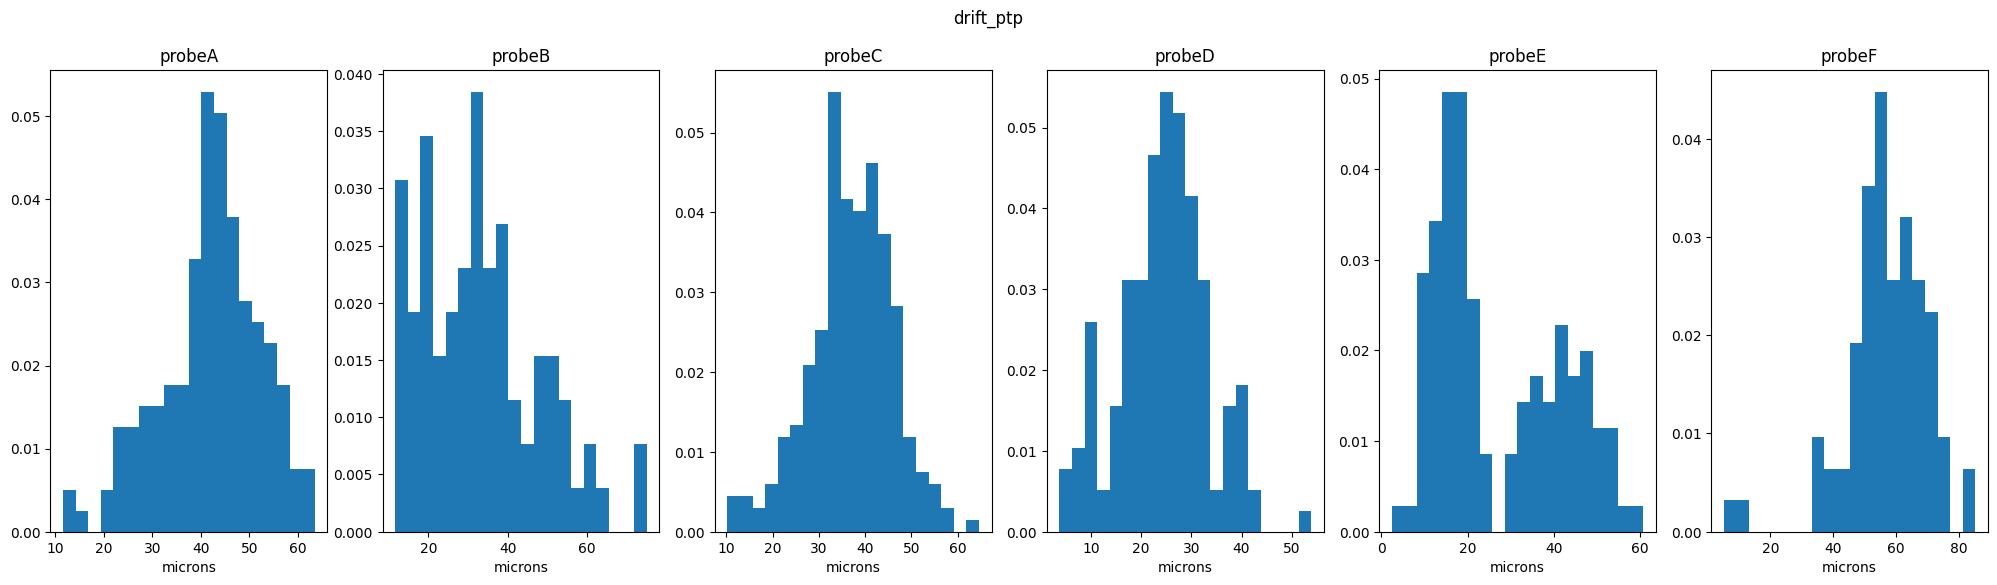

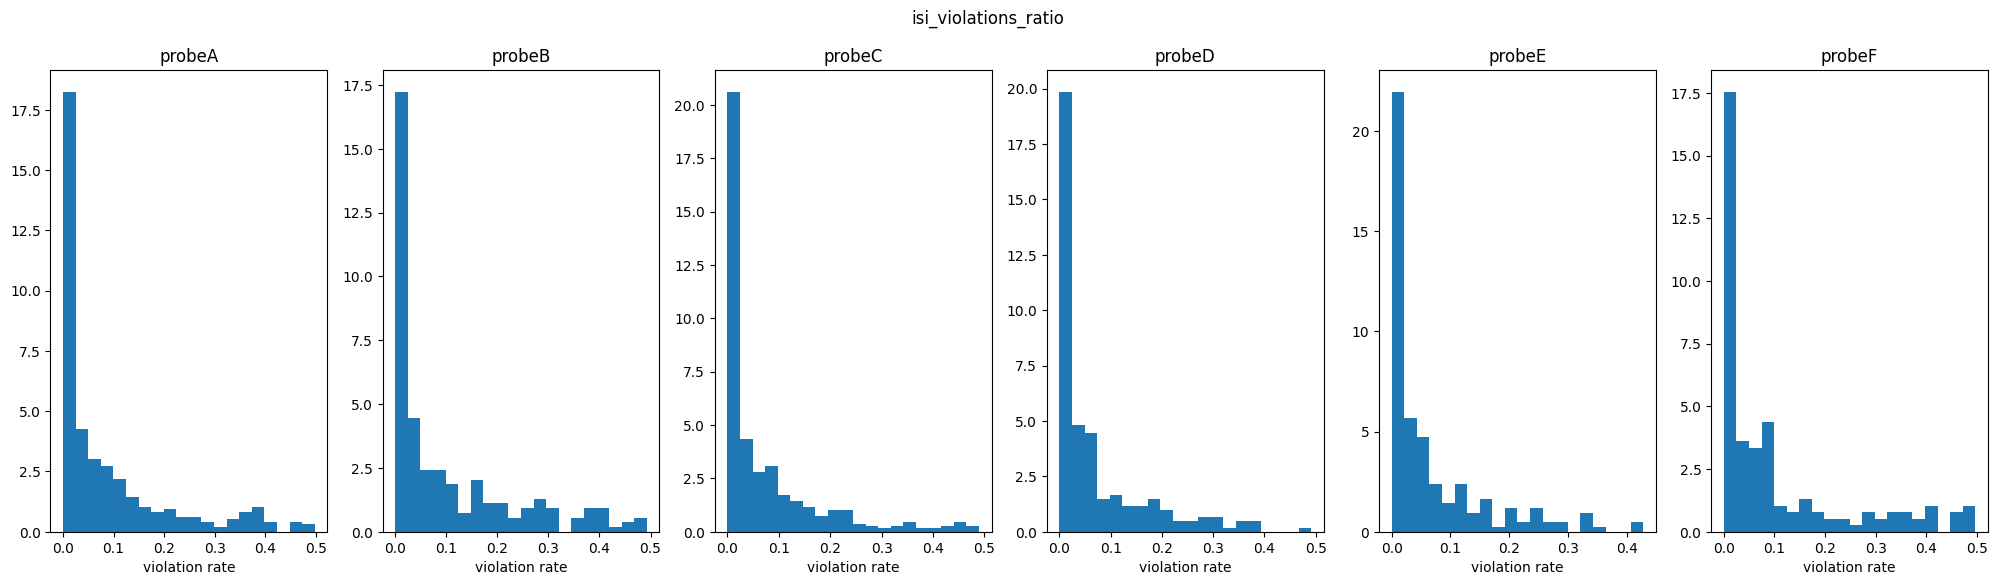

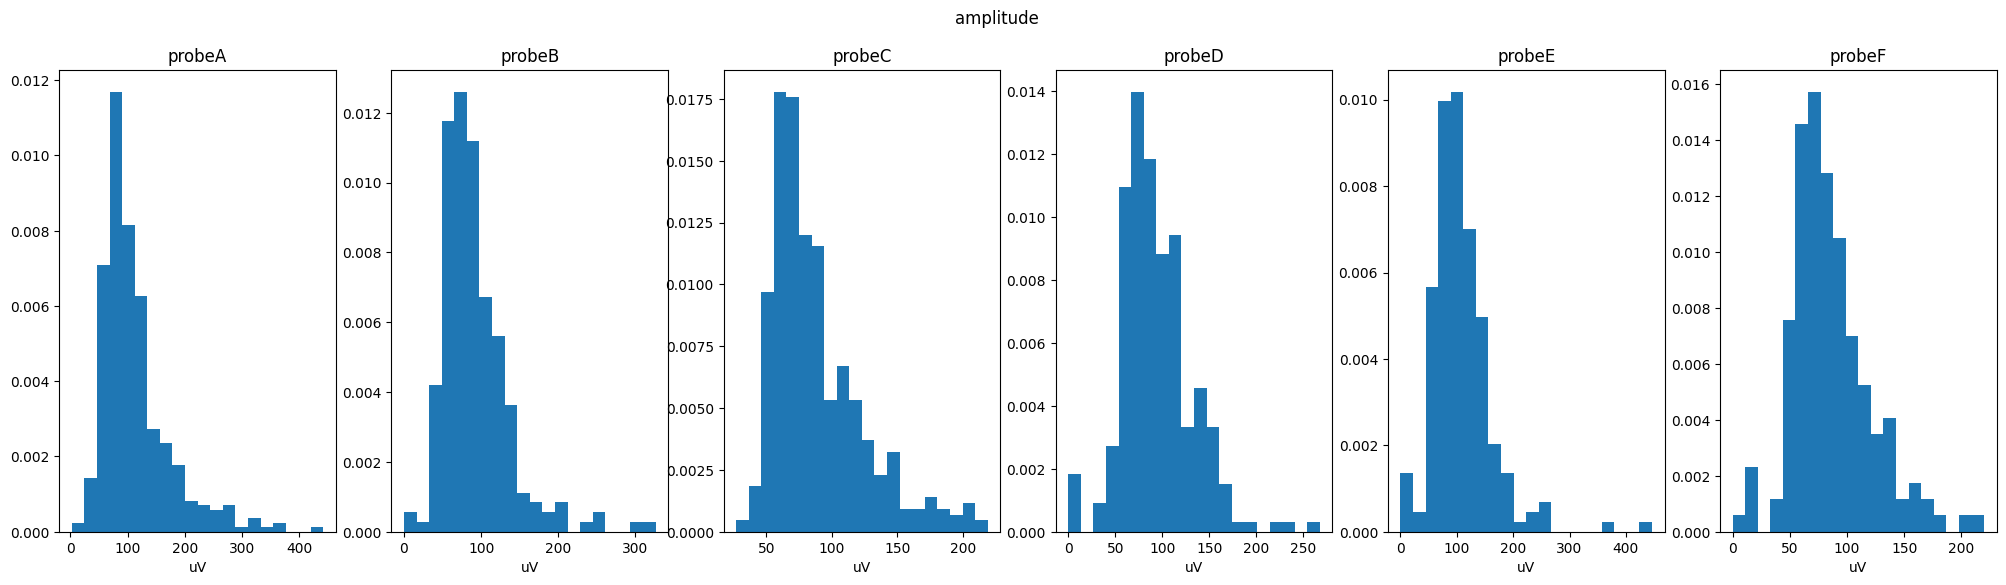

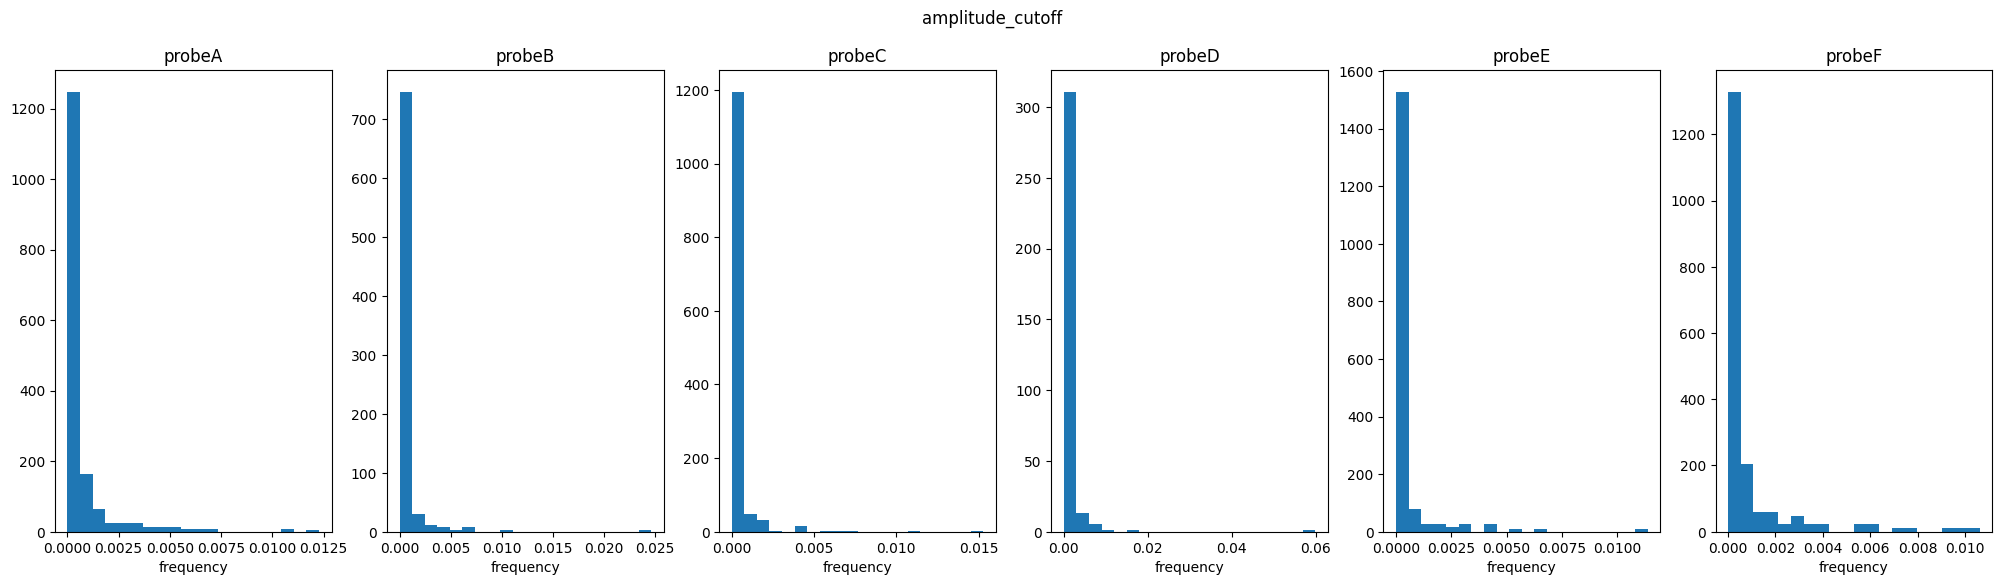

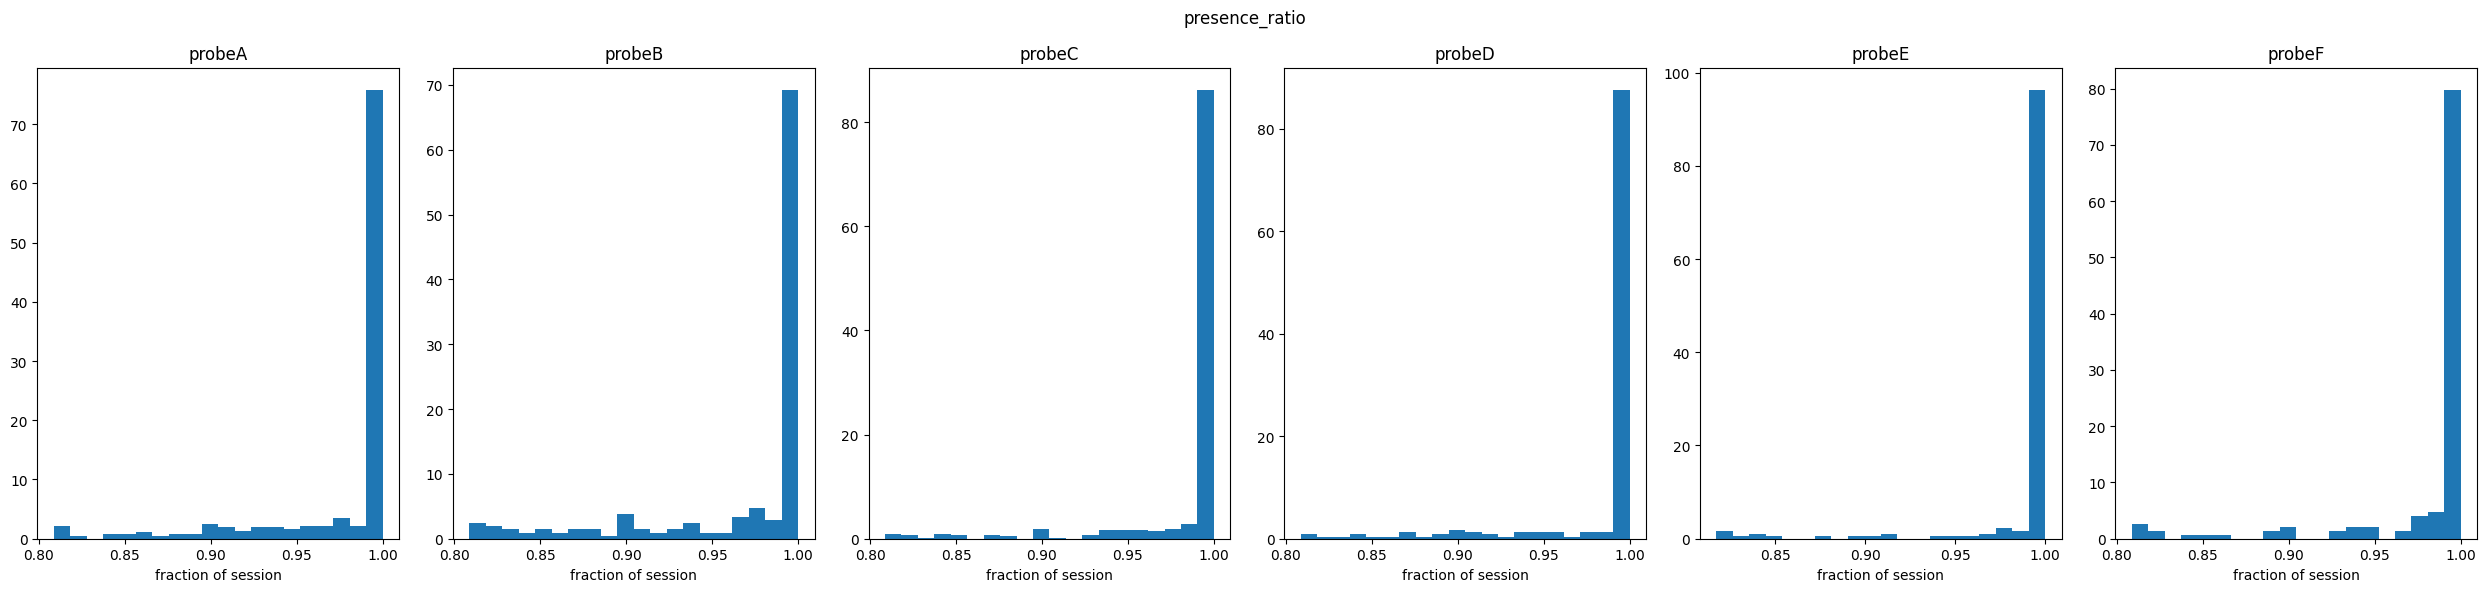

In [60]:
plot_unit_quality_metrics_per_probe(units)

In [ ]:
trials = nwb.trials[:]
vis_context_trials = trials[(trials['is_vis_target']) & (trials['is_vis_context'])]
opto_trials

In [ ]:
def plot_all_unit_spike_histograms(units: pd.DataFrame):
    probes = units['device_name'].unique()

    for probe in probes:
        fig, ax = plt.subplots()
        unit_spike_times = units[units['device_name'] == probe]['spike_times'].to_numpy()

        hist, bins = npc_sessions.bin_spike_times(unit_spike_times, bin_interval=1)
        ax.plot(hist)
        ax.set_title(f'{probe} Spike Histogram')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Spike Count per 1 second bin')

In [ ]:
plot_all_unit_spike_histograms(units_spikes_electrodes)

In [ ]:
def plot_unit_spikes_channels(units: pd.DataFrame, lower_channel: int, upper_channel: int):
    probes = units['device_name'].unique()
    for probe in probes:
        fig, ax = plt.subplots()
        unit_spike_times = units[units['device_name'] == probe]
        unit_spike_times_channel = unit_spike_times[(unit_spike_times['peak_channel'] >= lower_channel) & 
                                                    (unit_spike_times['peak_channel'] <= upper_channel)]['spike_times'].to_numpy()
        hist, bins = npc_sessions.bin_spike_times(unit_spike_times_channel, bin_interval=1)

        ax.plot(hist)
        ax.set_title(f'{probe} spike hist for channel range {lower_channel} to {upper_channel}')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Spike Count per 1 second bin')

In [ ]:
plot_unit_spikes_channels(units_spikes_electrodes, 0, 200)